# User profile using DNN Model

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler, LabelBinarizer
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical



# 1. Import encoded dataset

In [2]:
d5f = pd.read_csv('haircare_encoded_final2.csv')
d5f2 = pd.read_csv('hair Care Survey_v2 (Responses) - Form responses 1.csv')



# 2. Data cleaning

In [3]:
# Clean column names: strip whitespace, convert to lowercase, replace spaces and special chars

# Drop irrelevant columns (e.g., email, survey codes, etc.)
columns_to_drop = [
    'Timestamp', 'Score', 'Email', 'Email address',
    "SurveyCircle  \n  'Thank-you-for-your-participation' page. Please use the following text line that contains your Survey Code:",
    'Column 53', 'Would you participate in follow-up studies?'
]


d5f2.drop(columns=columns_to_drop, inplace=True, errors='ignore')

#Normalize Text Columns: Strip whitespace, Lowercase, Remove special character
d5f2.columns = (
    d5f2.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('[^a-zA-Z0-9_]', '', regex=True)
)

# 3. Data encoding

In [6]:
# Define columns to encode,

numeric_columns = [ 'consumed_waterday_l']

ordinal_columns = [ 'current_hair_condition', 'age', 'hair_porosity','hair_texture', 'hair_density', 'harline_condition',
                 'hair_breakage', 'hair_loss_state','hair_length_current_hair_length', 'hair_length_hair_goal', 'country', 'hair_type',
                  'how_often_do_you_heatstyling_tools', 'how_often_do_you_tight_hairstyle', 'how_often_do_you_hair_moisturizer',
       'how_often_do_you_scalp_massages', 'how_often_do_you_hair_wash',
       'occurrence_of_hair_breakage', 'causes_of_hair_breakage', 'occurrence_of_hair_breakage']

norminal_columns = [ 'race', 'gender', 'hair_edges_condition','hair_look', 'scalp_condition',
                    'is_your_hair_chemically_treated',
       'professional_treatments', 'protective_hairstyles_no_1','protective_hairstyles_no_2', 'condition_of_protective_hairstyles_used',
       'protective_hairstyles_maintenance','causes_of_hair_breakage',  'comb_type','detangling_style', 'eating_diet',
       'hair_state_and_their_cause_hydrated__healthy',
       'hair_state_and_their_cause_promote_frizzy',
       'hair_state_and_their_cause_tangled',
       'hair_state_and_their_cause_dryness__breaking']

sentence_columns = [ 'ingredient_promotes_your_hair_health','other_please_specify','hair_supplement_used',
                      'medication_or_condition_affecting_hair_growth','hair_or_scalp_allergies',
                       'tips_or_products_have_worked_well_for_your_hair', 'main_factor_influencing_your_hair_health_or_growth']
Binary_columns = ['keratin_treatment', 'family_history_of_hair_loss_or_slow_growth', 'satin_scarfbonnet_or_pillowcase', ]


In [25]:
#df = d5f2.copy(deep=True)
# -----------------------------------------------------
# 1. Numerical Column(s)
# -----------------------------------------------------
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# -----------------------------------------------------
# 2. Ordinal Columns → Gray Encoding
# -----------------------------------------------------
def to_gray_code(n):
    return n ^ (n >> 1)

def ordinal_to_gray(series):
    unique_vals = sorted(series.dropna().unique())
    mapping = {val: i for i, val in enumerate(unique_vals)}
    return series.map(mapping).fillna(0).astype(int).apply(to_gray_code)

for col in ordinal_columns:
    df[col] = ordinal_to_gray(df[col])
    #df[col] = ordinal_to_gray(df[col].astype(str).str.lower().str.strip())


# -----------------------------------------------------
# 3. Nominal Columns → Binary Encoding
# -----------------------------------------------------

def binary_encode_column(df, column):
    df[column] = df[column].astype(str).str.lower().str.strip()

    # If only 1 unique non-null value, skip encoding
    if df[column].nunique(dropna=True) <= 1:
        return pd.DataFrame(index=df.index)  # empty frame, safe for concat

    lb = LabelBinarizer()
    arr = lb.fit_transform(df[column])

    # Ensure arr is 2D
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)

    # Create matching column names for the number of array columns
    col_names = [f"{column}_{cls}" for cls in lb.classes_]
    if len(col_names) != arr.shape[1]:
        col_names = col_names[:arr.shape[1]]

    return pd.DataFrame(arr, columns=col_names, index=df.index)


binary_encoded_nominals = [binary_encode_column(df, col) for col in norminal_columns]
df_nominal_binary = pd.concat(binary_encoded_nominals, axis=1)

# -----------------------------------------------------
# 4. Binary Columns → Yes/No Mapping
# -----------------------------------------------------
binary_map = {'yes': 1, 'no': 0}
for col in Binary_columns:
    df[col] = df[col].astype(str).str.lower().str.strip().map(binary_map).fillna(0).astype(int)

# -----------------------------------------------------
# 5. Final Dataset
# -----------------------------------------------------
df_final = pd.concat([
    df[numeric_columns + ordinal_columns + Binary_columns], 
    df_nominal_binary.reset_index(drop=True)
], axis=1)

print("Final encoded dataset shape:", df_final.shape)

Final encoded dataset shape: (2, 37)


/var/folders/sd/2tmrf4ds7nqg7lk_wdy856vm0000gn/T/ipykernel_61389/4162696511.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
/var/folders/sd/2tmrf4ds7nqg7lk_wdy856vm0000gn/T/ipykernel_61389/4162696511.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = ordinal_to_gray(df[col])
/var/folders/sd/2tmrf4ds7nqg7lk_wdy856vm0000gn/T/ipykernel_61389/4162696511.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [75]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelBinarizer

df = d5f2.copy(deep=True)


class SurveyEncoder:
    def __init__(self, numeric_columns, ordinal_columns, nominal_columns, binary_columns):
        self.numeric_columns = numeric_columns
        self.ordinal_columns = ordinal_columns
        self.nominal_columns = nominal_columns
        self.binary_columns = binary_columns

        self.scaler = StandardScaler()
        self.ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        self.nominal_encoders = {}
        self.fitted = False

    def binary_encode_column(self, series, col):
        series = series.astype(str).str.lower().str.strip()

        if series.nunique(dropna=True) <= 1:
            return pd.DataFrame(index=series.index)  # empty frame

        lb = LabelBinarizer()
        arr = lb.fit_transform(series)

        # Ensure arr is 2D
        if arr.ndim == 1:
            arr = arr.reshape(-1, 1)

        # Handle binary vs multi-class properly
        if len(lb.classes_) == 2:
            col_names = [f"{col}_{lb.classes_[1]}"]  # single column for positive class
        else:
            col_names = [f"{col}_{cls}" for cls in lb.classes_]

        df_enc = pd.DataFrame(arr, columns=col_names, index=series.index)

        self.nominal_encoders[col] = lb
        return df_enc

    def fit(self, df):
        # Fit scaler for numeric
        self.scaler.fit(df[self.numeric_columns])

        # Fit ordinal encoder
        self.ordinal_encoder.fit(df[self.ordinal_columns])

        # Fit label binarizers for nominal and binary
        for col in self.nominal_columns + self.binary_columns:
            _ = self.binary_encode_column(df[col], col)

        self.fitted = True
        return self

    def transform(self, df):
        if not self.fitted:
            raise ValueError("Encoder must be fitted before transform.")

        parts = []

        # Numeric
        num_scaled = self.scaler.transform(df[self.numeric_columns])
        parts.append(pd.DataFrame(num_scaled, columns=self.numeric_columns, index=df.index))

        # Ordinal
        ord_enc = self.ordinal_encoder.transform(df[self.ordinal_columns])
        parts.append(pd.DataFrame(ord_enc, columns=self.ordinal_columns, index=df.index))

        # Nominal + Binary
        for col in self.nominal_columns + self.binary_columns:
            series = df[col].astype(str).str.lower().str.strip()
            lb = self.nominal_encoders[col]
            arr = lb.transform(series)

            if arr.ndim == 1:
                arr = arr.reshape(-1, 1)

            if len(lb.classes_) == 2:
                col_names = [f"{col}_{lb.classes_[1]}"]
            else:
                col_names = [f"{col}_{cls}" for cls in lb.classes_]

            parts.append(pd.DataFrame(arr, columns=col_names, index=df.index))

        return pd.concat(parts, axis=1)

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)



encoder = SurveyEncoder(numeric_columns, ordinal_columns, norminal_columns,Binary_columns)
df_final1 = encoder.fit_transform(df)

# Force shape to (132, 171)
if df_final1.shape[1] > 171:
    # Too many columns → drop extras
    df_final1 = df_final1.iloc[:, :171]
elif df_final1.shape[1] < 171:
    # Too few columns → add zeros
    missing_cols = 171 - df_final1.shape[1]
    for i in range(missing_cols):
        df_final1[f"pad_col_{i}"] = 0
        
print("Final encoded dataset shape:", df_final1.shape)
joblib.dump(encoder, "survey_encoder.pkl")


Final encoded dataset shape: (132, 171)


['survey_encoder.pkl']

In [85]:
import dill

# Saving encoder
with open("survey_encoder.pkl", "wb") as f:
    dill.dump(encoder, f)


# Loading (no need for class definition)
with open("survey_encoder.pkl", "rb") as f:
    encoder = dill.load(f)

ModuleNotFoundError: No module named 'dill'

# 4. Splitting data for training and testing

In [21]:
# === Step 2: label Target Labels ===

# === Check for NaNs ===
if df_final.isnull().values.any():
    print("⚠️ Found missing values — filling with 0")
    df_final = df_final.fillna(0)

# === Step 3: Features and Target ===
X = df_final.drop(columns=['current_hair_condition'])
#X = df_final.drop(columns=df_final[sentence_columns])

sentence_columns
# === Label encode string targets like "Dry", "Healthy", etc. ===
label_enc = LabelEncoder()
dfx= d5f2.copy(deep=True)

dfx['current_hair_condition'] = label_enc.fit_transform(dfx['current_hair_condition'])

if dfx.isnull().values.any():
    dfx = dfx.fillna(0)
    
# === Then do one-hot encoding ===
y = df_final['current_hair_condition']
y_cat = to_categorical(y)

# === Save class names for decoding later ===
class_names = label_enc.classes_

⚠️ Found missing values — filling with 0


# 5. Model training: DNN Hair health classification

In [70]:
# === Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)


# === Build Model ===
model = Sequential([
    Input(shape=(X_train.shape[1],)), 
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Step 7: Add EarlyStopping to monitor val_accuracy ===
from tensorflow.keras.callbacks import Callback

class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold=00.6471):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc > self.threshold:
            print(f"\n✅ Reached {val_acc:.2f} validation accuracy. Stopping training.")
            self.model.stop_training = True



acc_threshold = AccuracyThresholdCallback(threshold=0.75)

# === Step 8: Train the model ===
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[acc_threshold],
    verbose=1
)



# === Train Model ===
#model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32)



Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.2853 - loss: 4.1463 - val_accuracy: 0.2381 - val_loss: 1.7655
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4113 - loss: 3.3296 - val_accuracy: 0.3810 - val_loss: 1.7712
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4308 - loss: 3.1916 - val_accuracy: 0.3333 - val_loss: 1.9183
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3387 - loss: 3.9191 - val_accuracy: 0.1905 - val_loss: 2.2766
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4213 - loss: 2.6927 - val_accuracy: 0.1905 - val_loss: 2.5840
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4252 - loss: 3.1703 - val_accuracy: 0.5238 - val_loss: 2.0972
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4844 - loss: 3.4242 - val_accuracy: 0.4762 - val_loss: 2.4962
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3328 - loss: 4.2068 - val_accuracy: 0.5238 - val_loss

# 6. Evaluate the Model

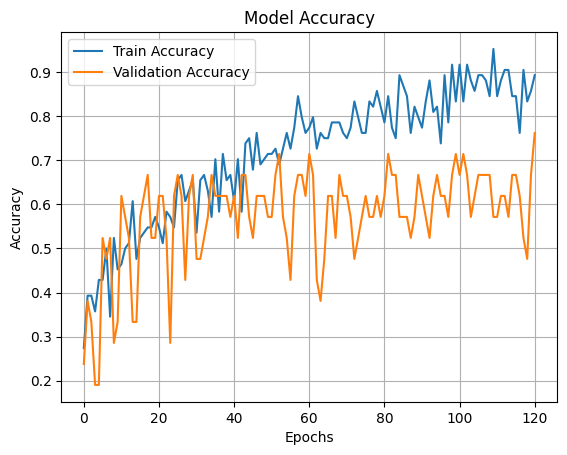

In [71]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 7. Save the DNN Hair health classification model

In [74]:
 model.save("DNN_hair_Health_classifier.h5")